In [1]:
using Pkg
Pkg.activate("../")

folder = "../idealized_coast_unforced/"
closure = "unforced"

using Suppressor
@suppress begin
    using Oceananigans, CairoMakie, TimestepperTestCases, Statistics
end

  Activating project at `~/development/TimestepperTestCases.jl`


In [2]:
GC.gc()
@time rl = @suppress TimestepperTestCases.load_idealized_coast(folder, closure * "_full", "split_free_surface_lowres_", "SplitRungeKutta3");

272.525100 seconds (274.95 M allocations: 103.070 GiB, 7.42% gc time, 41.76% compilation time: 1% of which was recompilation)


In [3]:
GC.gc()
@time al = @suppress TimestepperTestCases.load_idealized_coast(folder * "old/", closure, "split_free_surface_lowres_", "QuasiAdamsBashforth2");

164.090319 seconds (30.88 M allocations: 90.744 GiB, 11.00% gc time, 0.00% compilation time)


In [4]:
GC.gc()
@time ri = @suppress TimestepperTestCases.load_idealized_coast(folder, closure * "_full", "implicit_free_surface_lowres_", "SplitRungeKutta3");

366.529008 seconds (30.86 M allocations: 90.743 GiB, 4.53% gc time, 0.02% compilation time)


In [5]:
function line_mean(field)
  Ny, Nz = size(field)
  lm = zeros(Nz)
  sz = zeros(Int, Nz)
  @inbounds for k in 1:Nz, j in 1:Ny
        if !isnan(field[j, k])
            lm[k] += field[j, k]
            sz[k] += 1
        end
   end
   return lm ./ sz
end 

using LaTeXStrings

ticks(vec) = (vec, latexstring.(string.(vec)))

function running_mean(v, points)
    n  = length(v)
    rm = zeros(length(v) - 2points+1)
    for i in points+1:n-points
        rm[i-points] = mean(v[i - points:i+points])
    end
    return rm[1:end-1]
end

running_mean (generic function with 1 method)

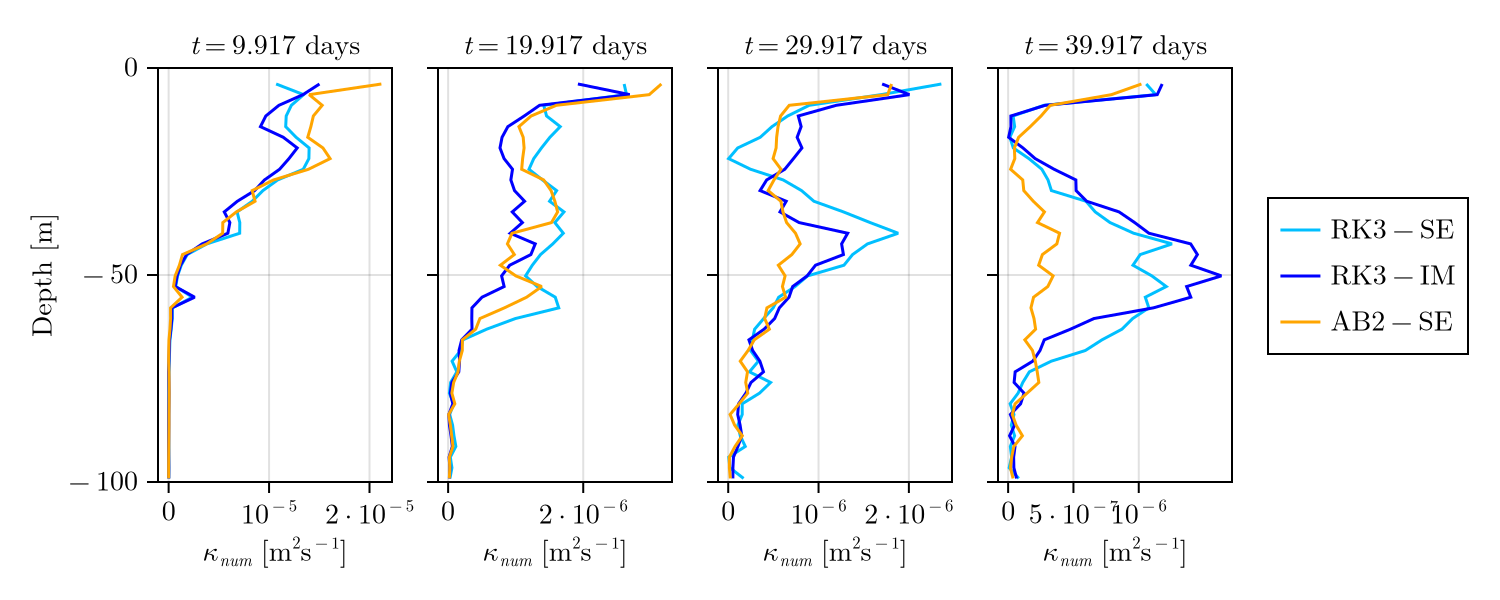

CairoMakie.Screen{PDF}


In [6]:
c1 = :deepskyblue 
c2 = :blue
c3 = :orange1 
c4 = :steelblue

mvv = 8

zC  = ri[:Abx].grid.z.cᵃᵃᶜ[2:39] 
fig = Figure(size = (750, 300))

xticks1 = ([0, 1e-5, 2e-5], [L"0", L"10^{-5}", L"2 \cdot 10^{-5}"])
xticks2 = ([0, 3e-5, 6e-5, 9e-5], [L"0", L"3\cdot 10^{-5}", L"6 \cdot 10^{-5}", L"9 \cdot 10^{-5}"])
xticks3 = ([0, 2e-5, 4e-5, 6e-5], [L"0", L"2\cdot 10^{-5}", L"4 \cdot 10^{-5}", L"6 \cdot 10^{-5}"])
xticks4 = ([0, 5e-5, 1e-4, 1.5e-4], [L"0", L"5\cdot 10^{-5}", L"10^{-4}", L"1.5 \cdot 10^{-4}"])

xlabel = L"\kappa_{num} \text{ [m}^2\text{s}^{-1}\text{]}"

it1 = 120
it2 = 240
it3 = 360
it4 = 480

ax1 = Axis(fig[1, 1]; 
           xlabel,
           xticks = ([0, 1e-5, 2e-5], [L"0", L"10^{-5}", L"2\cdot 10^{-5}"]),
           ylabel = L"\text{Depth [m]}",
           yticks = ticks([-100, -50, 0]),
           title=L"t = \text{%$(Oceananigans.Utils.prettytime(rl[:Abz].times[it1]))}") 
ax2 = Axis(fig[1, 2]; 
           xlabel,
           xticks = ([0, 2e-6, 4e-6], [L"0", L"2\cdot 10^{-6}", L"4\cdot 10^{-6}"]),
           ylabel = "",
           yticks = ([-100, -50, 0], ["", "", ""]),
           title=L"t = \text{%$(Oceananigans.Utils.prettytime(rl[:Abz].times[it2]))}") 
ax3 = Axis(fig[1, 3]; 
           xlabel,
           xticks = ([0, 1e-6, 2e-6], [L"0", L"10^{-6}", L"2\cdot 10^{-6}"]),
           ylabel = "",
           yticks = ([-100, -50, 0], ["", "", ""]),
           title=L"t = \text{%$(Oceananigans.Utils.prettytime(rl[:Abz].times[it3]))}") 
ax4 = Axis(fig[1, 4]; 
           xlabel,
           xticks = ([0, 5e-7, 1e-6], [L"0", L"5\cdot 10^{-7}", L"10^{-6}"]),
           ylabel = "",
           yticks = ([-100, -50, 0], ["", "", ""]),
           title=L"t = \text{%$(Oceananigans.Utils.prettytime(rl[:Abz].times[it4]))}") 

α   = 1.0
ϵ   = 1e-20
it  = it1
κrl = abs.(line_mean(interior(Field(mean(rl[:Abz][it] + rl[:Aby][it] + rl[:Abx][it], dims=1) / (mean(rl[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κri = abs.(line_mean(interior(Field(mean(ri[:Abz][it] + ri[:Aby][it] + ri[:Abx][it], dims=1) / (mean(ri[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κal = abs.(line_mean(interior(Field(mean(al[:Abz][it] + al[:Aby][it] + al[:Abx][it], dims=1) / (mean(al[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
lines!(ax1, κrl, zC, color = (c1, α))
lines!(ax1, κri, zC, color = (c2, α))
lines!(ax1, κal, zC, color = (c3, α))
it  = it2
κrl = abs.(line_mean(interior(Field(mean(rl[:Abz][it] + rl[:Aby][it] + rl[:Abx][it], dims=1) / (mean(rl[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κri = abs.(line_mean(interior(Field(mean(ri[:Abz][it] + ri[:Aby][it] + ri[:Abx][it], dims=1) / (mean(ri[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κal = abs.(line_mean(interior(Field(mean(al[:Abz][it] + al[:Aby][it] + al[:Abx][it], dims=1) / (mean(al[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
lines!(ax2, κrl, zC, color = (c1, α))
lines!(ax2, κri, zC, color = (c2, α))
lines!(ax2, κal, zC, color = (c3, α))
it  = it3
κrl = abs.(line_mean(interior(Field(mean(rl[:Abz][it] + rl[:Aby][it] + rl[:Abx][it], dims=1) / (mean(rl[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κri = abs.(line_mean(interior(Field(mean(ri[:Abz][it] + ri[:Aby][it] + ri[:Abx][it], dims=1) / (mean(ri[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κal = abs.(line_mean(interior(Field(mean(al[:Abz][it] + al[:Aby][it] + al[:Abx][it], dims=1) / (mean(al[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
lines!(ax3, κrl, zC, color = (c1, α))
lines!(ax3, κri, zC, color = (c2, α))
lines!(ax3, κal, zC, color = (c3, α))
it  = it4
κrl = abs.(line_mean(interior(Field(mean(rl[:Abz][it] + rl[:Aby][it] + rl[:Abx][it], dims=1) / (mean(rl[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κri = abs.(line_mean(interior(Field(mean(ri[:Abz][it] + ri[:Aby][it] + ri[:Abx][it], dims=1) / (mean(ri[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
κal = abs.(line_mean(interior(Field(mean(al[:Abz][it] + al[:Aby][it] + al[:Abx][it], dims=1) / (mean(al[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]
lines!(ax4, κrl, zC, color = (c1, α), label=L"\text{RK3-SE}")
lines!(ax4, κri, zC, color = (c2, α), label=L"\text{RK3-IM}")
lines!(ax4, κal, zC, color = (c3, α), label=L"\text{AB2-SE}")
ylims!(ax1, -100, 0)
ylims!(ax2, -100, 0)
ylims!(ax3, -100, 0)
ylims!(ax4, -100, 0)
Legend(fig[1, 5], ax4)
display(current_figure())
path = "/Users/simonesilvestri/Dropbox (MIT)/Apps/Overleaf/timestepper/"

CairoMakie.save(path * "dissipation-coast.pdf", fig)

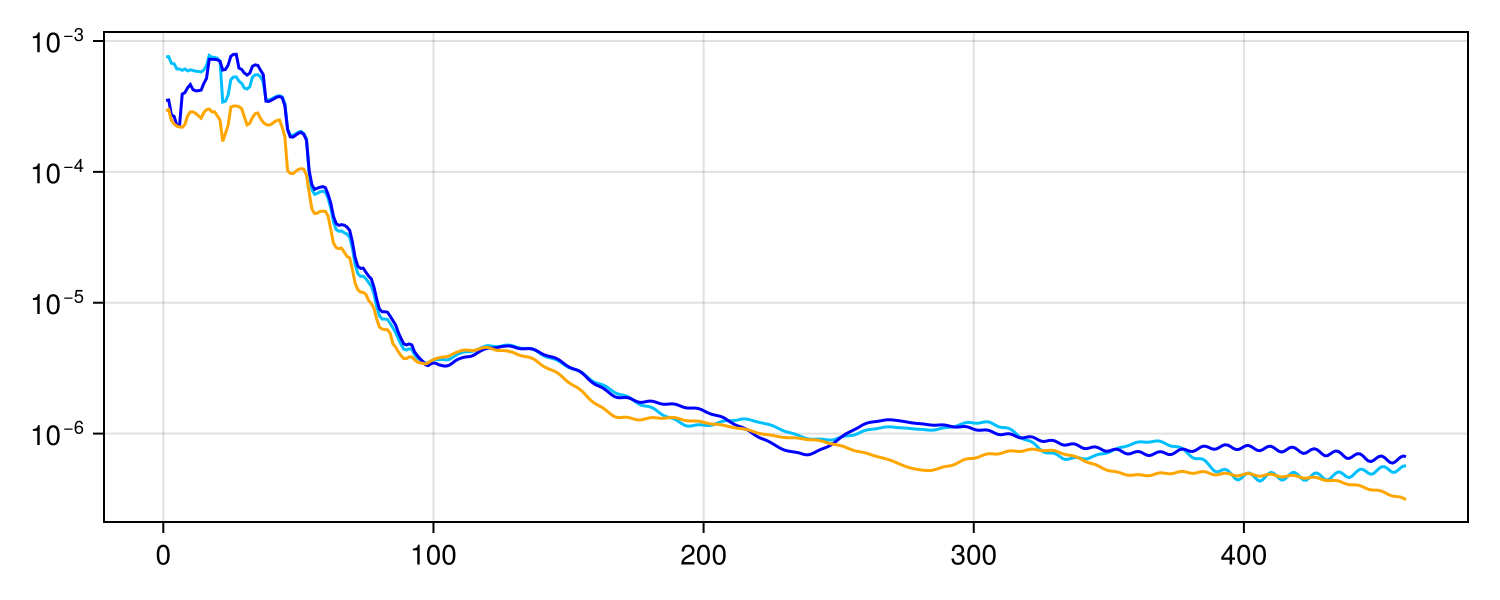

CairoMakie.Screen{PDF}


In [27]:
zC  = ri[:Abx].grid.z.cᵃᵃᶜ[2:39] 
fig = Figure(size = (750, 300))

xticks1 = ([0, 1e-5, 2e-5], [L"0", L"10^{-5}", L"2 \cdot 10^{-5}"])
xticks2 = ([0, 3e-5, 6e-5, 9e-5], [L"0", L"3\cdot 10^{-5}", L"6 \cdot 10^{-5}", L"9 \cdot 10^{-5}"])
xticks3 = ([0, 2e-5, 4e-5, 6e-5], [L"0", L"2\cdot 10^{-5}", L"4 \cdot 10^{-5}", L"6 \cdot 10^{-5}"])
xticks4 = ([0, 5e-5, 1e-4, 1.5e-4], [L"0", L"5\cdot 10^{-5}", L"10^{-4}", L"1.5 \cdot 10^{-4}"])

xlabel = L"\kappa_{num} \text{ [m}^2\text{s}^{-1}\text{]}"

ax1 = Axis(fig[1, 1], yscale=log10)

# κrl = Float64[]
# κri = Float64[]
# κal = Float64[]

# for it in 1:480
#     push!(κrl,  mean(abs.(line_mean(interior(Field(mean(rl[:Abz][it] + rl[:Aby][it] + rl[:Abx][it], dims=1) / (mean(rl[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]))
#     push!(κri,  mean(abs.(line_mean(interior(Field(mean(ri[:Abz][it] + ri[:Aby][it] + ri[:Abx][it], dims=1) / (mean(ri[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]))
#     push!(κal,  mean(abs.(line_mean(interior(Field(mean(al[:Abz][it] + al[:Aby][it] + al[:Abx][it], dims=1) / (mean(al[:Gbz][it], dims=1) + ϵ) / 2), 1, :, :)))[2:39]))
# end

lines!(ax1, running_mean(abs.(κrl .+ 1e-20), 10), color = (c1, α))
lines!(ax1, running_mean(abs.(κri .+ 1e-20), 10), color = (c2, α))
lines!(ax1, running_mean(abs.(κal .+ 1e-20), 10), color = (c3, α))
display(current_figure())
path = "/Users/simonesilvestri/Dropbox (MIT)/Apps/Overleaf/timestepper/"

CairoMakie.save(path * "dissipation-avg-coast.pdf", fig)

[ Info: 22.0


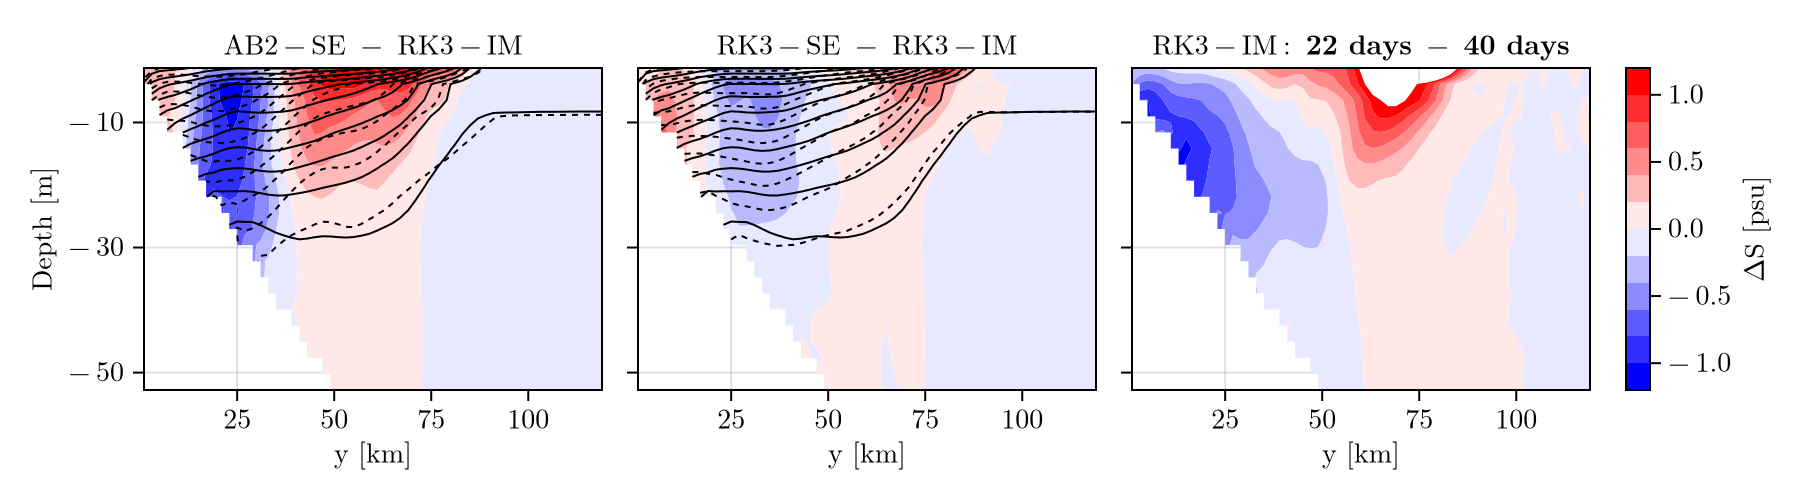

CairoMakie.Screen{PDF}


In [65]:
fig = Figure(size = (900, 250))
jr  = 1:60
kr  = 20:40
zC  = ri[:S].grid.z.cᵃᵃᶜ[kr]
yC  = ri[:S].grid.yᵃᶜᵃ[jr] ./ 1e3
ax1  = Axis(fig[1, 1], title = L"\text{AB2-SE - RK3-IM}",
                       ylabel = L"\text{Depth [m]}",
                       xlabel = L"\text{y [km]}",
                       xticks = ticks([0, 25, 50, 75, 100]),
                       yticks = ticks([-50, -30, -10]))

contourf!(ax1, yC, zC, interior(mean(al[:S][end] / al[:VCCC][end], dims=1), 1, jr, kr) .- interior(mean(ri[:S][end] / ri[:VCCC][end], dims=1), 1, jr, kr), levels = -1.2:0.2:1.2, colormap = :bwr)
contour!(ax1,  yC, zC, interior(mean(al[:b][end] / al[:VCCC][end], dims=1),  1, jr, kr), levels = range(-0.22, -0.17, length=12), color = :black, linestyle=:dash)
contour!(ax1,  yC, zC, interior(mean(ri[:b][end] / ri[:VCCC][end], dims=1),  1, jr, kr), levels = range(-0.22, -0.17, length=12), color = :black)
xlims!(ax1, yC[1], yC[end])
ylims!(ax1, zC[1], zC[end])

ax2  = Axis(fig[1, 2], title = L"\text{RK3-SE - RK3-IM}",
                      ylabel = "",
                      xlabel = L"\text{y [km]}",
                      xticks = ticks([0, 25, 50, 75, 100]),
                      yticks = ([-50, -30, -10], ["", "", ""]))

contourf!(ax2, yC, zC, interior(mean(rl[:S][end] / rl[:VCCC][end], dims=1), 1, jr, kr) .- interior(mean(ri[:S][end] / ri[:VCCC][end], dims=1), 1, jr, kr), levels = -1.2:0.2:1.2, colormap = :bwr)
contour!(ax2,  yC, zC, interior(mean(rl[:b][end] / rl[:VCCC][end], dims=1),  1, jr, kr), levels = range(-0.22, -0.17, length=12), color = :black, linestyle=:dash)
contour!(ax2,  yC, zC, interior(mean(ri[:b][end] / ri[:VCCC][end], dims=1),  1, jr, kr), levels = range(-0.22, -0.17, length=12), color = :black)
xlims!(ax2, yC[1], yC[end])
ylims!(ax2, zC[1], zC[end])

ax3 = Axis(fig[1, 3], title = L"\text{RK3-IM: \textbf{22 days} - \textbf{40 days}}",
                     ylabel = "",
                     xlabel = L"\text{y [km]}",
                     xticks = ticks([0, 25, 50, 75, 100]),
                     yticks = ([-50, -30, -10], ["", "", ""]))

@info ri[:S].times[265] / 86400

hm  = contourf!(ax3, yC, zC, interior(mean(ri[:S][265] / ri[:VCCC][265], dims=1), 1, jr, kr) .- interior(mean(ri[:S][end] / ri[:VCCC][end], dims=1), 1, jr, kr), levels = -1.2:0.2:1.2, colormap = :bwr)
xlims!(ax3, yC[1], yC[end])
ylims!(ax3, zC[1], zC[end])
Colorbar(fig[1, 4], hm, label = L"\Delta \text{S [psu]}", ticks = ticks([-1, -0.5, 0.0, 0.5, 1.0]))
display(fig)
CairoMakie.save(path * "mean-coast.pdf", fig)

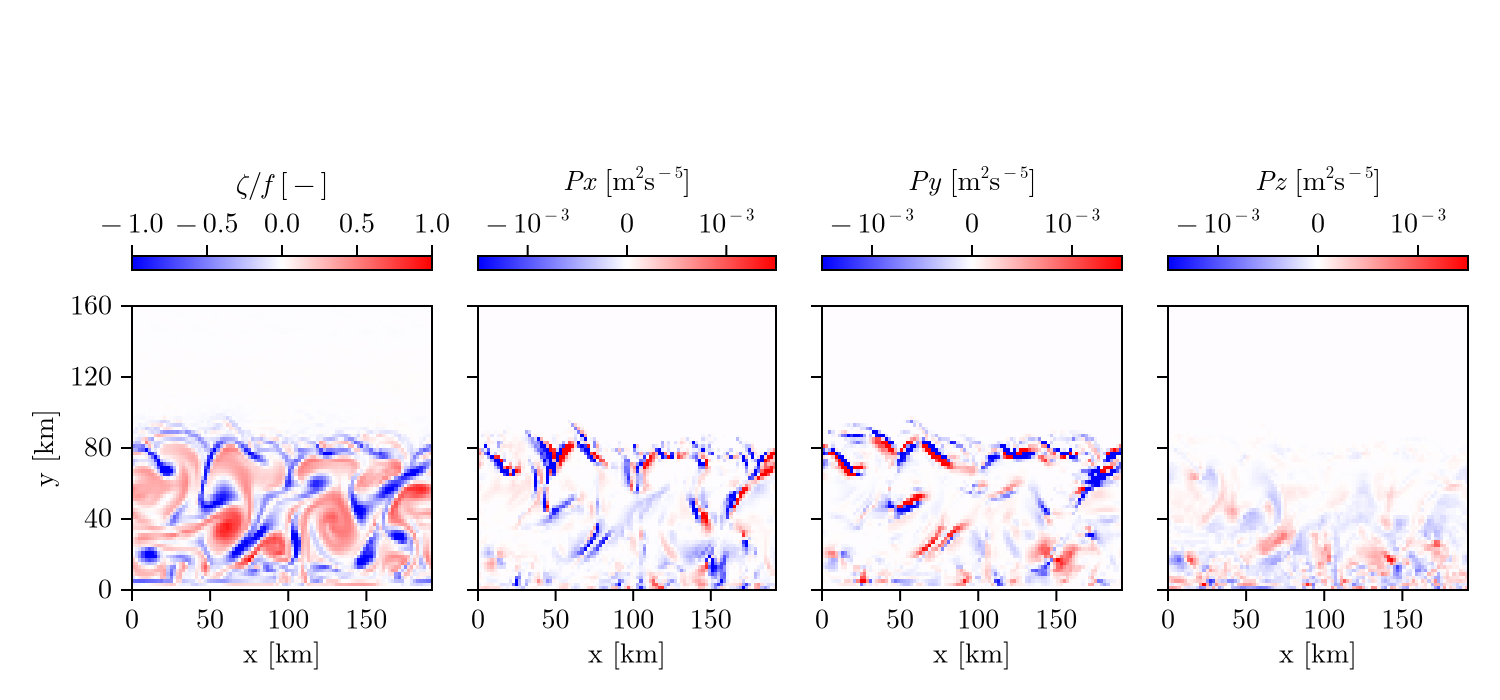

CairoMakie.Screen{PDF}


In [9]:
fig = Figure(size = (750, 350))
g1  = GridLayout(fig[1, 1]) 
g2  = GridLayout(fig[1, 2]) 
g3  = GridLayout(fig[1, 3]) 
g4  = GridLayout(fig[1, 4]) 
jr  = 1:80
yC  = ri[:S].grid.xᶜᵃᵃ[jr] ./ 1e3
xC  = ri[:S].grid.xᶜᵃᵃ[1:96] ./ 1e3
ax1 = Axis(g1[2, 1], xlabel=L"\text{x [km]}", xticks=ticks([0, 50, 100, 150]), ylabel=L"\text{y [km]}", yticks=ticks([0, 40, 80, 120, 160]))
ax2 = Axis(g2[2, 1], xlabel=L"\text{x [km]}", xticks=ticks([0, 50, 100, 150]), ylabel="", yticks=([0, 40, 80, 120, 160], ["", "", "", "", ""]))
ax3 = Axis(g3[2, 1], xlabel=L"\text{x [km]}", xticks=ticks([0, 50, 100, 150]), ylabel="", yticks=([0, 40, 80, 120, 160], ["", "", "", "", ""]))
ax4 = Axis(g4[2, 1], xlabel=L"\text{x [km]}", xticks=ticks([0, 50, 100, 150]), ylabel="", yticks=([0, 40, 80, 120, 160], ["", "", "", "", ""]))
iter = Observable(1)
un1 = @lift(interior(Field(∂y(rl[:u][$iter] / rl[:VFCC][$iter]) - ∂x(rl[:v][$iter] / rl[:VCFC][$iter])), :, jr, 40) ./ 1e-4)
un2 = @lift(interior(rl[:Abx][$iter], :, jr, 40))
un3 = @lift(interior(rl[:Aby][$iter], :, jr, 40))
un4 = @lift(interior(rl[:Abz][$iter], :, jr, 40))
hm1 = heatmap!(ax1, xC, yC, un1, colorrange=(-1, 1), colormap = :bwr)
hm2 = heatmap!(ax2, xC, yC, un2, colorrange=(-1.5e-3, 1.5e-3), colormap = :bwr)
hm3 = heatmap!(ax3, xC, yC, un3, colorrange=(-1.5e-3, 1.5e-3), colormap = :bwr)
hm4 = heatmap!(ax4, xC, yC, un4, colorrange=(-1.5e-3, 1.5e-3), colormap = :bwr)
Colorbar(g1[1, 1], hm1, label=L"\zeta / f \text{ [-]}", vertical=false, ticks=ticks([-1, -0.5, 0, 0.5, 1]), height=Relative(1/20))
Colorbar(g2[1, 1], hm2, label=L"Px \text{ [m}^2\text{s}^{-5}\text{]}", vertical=false, ticks=([-1e-3, 0, 1e-3], [L"-10^{-3}", L"0", L"10^{-3}"]), height=Relative(1/20))
Colorbar(g3[1, 1], hm3, label=L"Py \text{ [m}^2\text{s}^{-5}\text{]}", vertical=false, ticks=([-1e-3, 0, 1e-3], [L"-10^{-3}", L"0", L"10^{-3}"]), height=Relative(1/20))
Colorbar(g4[1, 1], hm4, label=L"Pz \text{ [m}^2\text{s}^{-5}\text{]}", vertical=false, ticks=([-1e-3, 0, 1e-3], [L"-10^{-3}", L"0", L"10^{-3}"]), height=Relative(1/20))
rowgap!(g1, -50)
rowgap!(g2, -50)
rowgap!(g3, -50)
rowgap!(g4, -50)

iter[] = 481
display(current_figure())

CairoMakie.save(path * "snapshots-coast.pdf", fig)

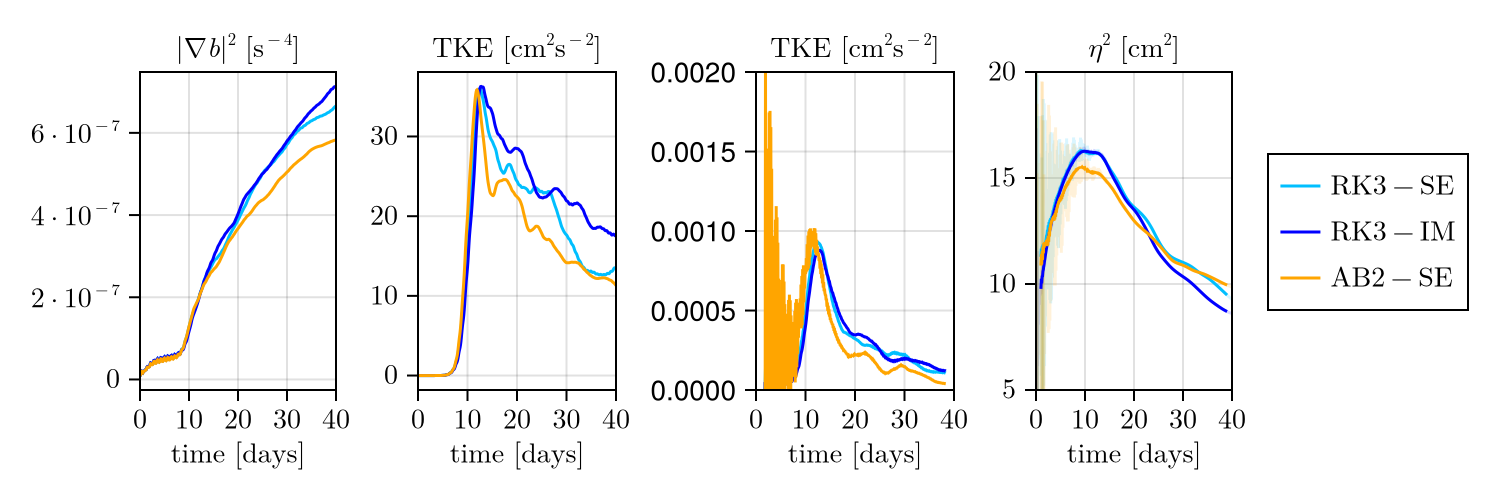

CairoMakie.Screen{PDF}


In [43]:
fig = Figure(size = (750, 250))
times = ri[:Abx].times ./ 86400
ax = Axis(fig[1, 1], xlabel=L"\text{time [days]}", xticks=ticks([0, 10, 20, 30, 40]), yticks = ([0, 2e-7, 4e-7, 6e-7], [L"0", L"2\cdot10^{-7}", L"4\cdot10^{-7}", L"6\cdot10^{-7}"]), title=L"|\nabla b|^2 \text{ [s}^{-4}\text{]}")
lines!(ax, times, rl[:gbt], color=c1)
lines!(ax, times, ri[:gbt], color=c2)
lines!(ax, times, al[:gbt], color=c3)
xlims!(ax, 0, 40)

ax = Axis(fig[1, 2], xlabel=L"\text{time [days]}", xticks=ticks([0, 10, 20, 30, 40]), yticks=ticks([0, 10, 20, 30]), title=L"\text{TKE [cm}^2\text{s}^{-2}\text{]}")
lines!(ax, times, (rl[:KE] .- rl[:MKE]) .* 1e4, color=c1)
lines!(ax, times, (ri[:KE] .- ri[:MKE]) .* 1e4, color=c2)
lines!(ax, times, (al[:KE] .- al[:MKE]) .* 1e4, color=c3)
xlims!(ax, 0, 40)

rlinc = [rl[:RPE][i] - rl[:RPE][i-1] for i in 2:length(rl[:RPE])]
riinc = [ri[:RPE][i] - ri[:RPE][i-1] for i in 2:length(rl[:RPE])]
alinc = [al[:RPE][i] - al[:RPE][i-1] for i in 2:length(rl[:RPE])]

ax = Axis(fig[1, 3], xlabel=L"\text{time [days]}", xticks=ticks([0, 10, 20, 30, 40]), title=L"\text{TKE [cm}^2\text{s}^{-2}\text{]}")
lines!(ax, running_mean(times[2:end], 20), running_mean(rlinc, 20), color=c1)
lines!(ax, running_mean(times[2:end], 20), running_mean(riinc, 20), color=c2)
lines!(ax, running_mean(times[2:end], 20), running_mean(alinc, 20), color=c3)
xlims!(ax, 0, 40)
ylims!(ax, 0, 0.002)

ax = Axis(fig[1, 4], xlabel=L"\text{time [days]}", xticks=ticks([0, 10, 20, 30, 40]), yticks=ticks([5, 10, 15, 20]), title=L"\eta^2 \text{ [cm}^2\text{]}")
lines!(ax, times, rl[:η2] .* 1e4, color=(c1, 0.15))
lines!(ax, times, ri[:η2] .* 1e4, color=(c2, 0.15))
lines!(ax, times, al[:η2] .* 1e4, color=(c3, 0.15))
lines!(ax, running_mean(times, 12), running_mean(rl[:η2], 12) .* 1e4, color=c1, label=L"\text{RK3-SE}")
lines!(ax, running_mean(times, 12), running_mean(ri[:η2], 12) .* 1e4, color=c2, label=L"\text{RK3-IM}")
lines!(ax, running_mean(times, 12), running_mean(al[:η2], 12) .* 1e4, color=c3, label=L"\text{AB2-SE}")
xlims!(ax, 0, 40)
ylims!(ax, 5, 20)

Legend(fig[1, 5], ax)

display(fig)
CairoMakie.save(path * "energetics-coast.pdf", fig)

In [50]:
### Compute the spectra
Nx, Ny, Nz = size(rl[:u][end])

jrange = 5:Ny÷2
kvalue = Nz-5

Url, freq = TimestepperTestCases.y_average_spectra(Field(rl[:u][end] / rl[:VFCC][end]), 1:Nx, jrange; k=kvalue)
Vrl, _    = TimestepperTestCases.y_average_spectra(Field(rl[:v][end] / rl[:VCFC][end]), 1:Nx, jrange; k=kvalue)
Wrl, _    = TimestepperTestCases.y_average_spectra(Field(rl[:w][end] / rl[:VCCF][end]), 1:Nx, jrange; k=kvalue)
Brl, _    = TimestepperTestCases.y_average_spectra(Field(rl[:b][end] / rl[:VCCC][end]), 1:Nx, jrange; k=kvalue)
Hrl, _    = TimestepperTestCases.y_average_spectra(rl[:η][end], 1:Nx, jrange; k=1)

Uri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:u][end] / ri[:VFCC][end]), 1:Nx, jrange; k=kvalue)
Vri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:v][end] / ri[:VCFC][end]), 1:Nx, jrange; k=kvalue)
Wri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:w][end] / ri[:VCCF][end]), 1:Nx, jrange; k=kvalue)
Bri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:b][end] / ri[:VCCC][end]), 1:Nx, jrange; k=kvalue)
Hri, _ = TimestepperTestCases.y_average_spectra(ri[:η][end], 1:Nx, jrange; k=1)

Ual, _ = TimestepperTestCases.y_average_spectra(Field(al[:u][end] / al[:VFCC][end]), 1:Nx, jrange; k=kvalue)
Val, _ = TimestepperTestCases.y_average_spectra(Field(al[:v][end] / al[:VCFC][end]), 1:Nx, jrange; k=kvalue)
Wal, _ = TimestepperTestCases.y_average_spectra(Field(al[:w][end] / al[:VCCF][end]), 1:Nx, jrange; k=kvalue)
Bal, _ = TimestepperTestCases.y_average_spectra(Field(al[:b][end] / al[:VCCC][end]), 1:Nx, jrange; k=kvalue)
Hal, _ = TimestepperTestCases.y_average_spectra(al[:η][end], 1:Nx, jrange; k=1)

init = 200
fina = 480
Nfiles = fina - init

specUrl = real.(Url) ./ Nfiles
specVrl = real.(Vrl) ./ Nfiles
specWrl = real.(Wrl) ./ Nfiles
specHrl = real.(Hrl) ./ Nfiles
specBrl = real.(Brl) ./ Nfiles

specUri = real.(Uri) ./ Nfiles
specVri = real.(Vri) ./ Nfiles
specWri = real.(Wri) ./ Nfiles
specHri = real.(Hri) ./ Nfiles
specBri = real.(Bri) ./ Nfiles

specUal = real.(Ual) ./ Nfiles
specVal = real.(Val) ./ Nfiles
specBal = real.(Bal) ./ Nfiles
specHal = real.(Hal) ./ Nfiles
specWal = real.(Wal) ./ Nfiles

for t in init:fina
    Url, freq = TimestepperTestCases.y_average_spectra(Field(rl[:u][t] / rl[:VFCC][t]), 1:Nx, jrange; k=kvalue)
    Vrl, _    = TimestepperTestCases.y_average_spectra(Field(rl[:v][t] / rl[:VCFC][t]), 1:Nx, jrange; k=kvalue)
    Wrl, _    = TimestepperTestCases.y_average_spectra(Field(rl[:w][t] / rl[:VCCF][t]), 1:Nx, jrange; k=kvalue)
    Brl, _    = TimestepperTestCases.y_average_spectra(Field(rl[:b][t] / rl[:VCCC][t]), 1:Nx, jrange; k=kvalue)
    Hrl, _    = TimestepperTestCases.y_average_spectra(rl[:η][t], 1:Nx, jrange; k=1)

    Uri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:u][t] / ri[:VFCC][t]), 1:Nx, jrange; k=kvalue)
    Vri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:v][t] / ri[:VCFC][t]), 1:Nx, jrange; k=kvalue)
    Wri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:w][t] / ri[:VCCF][t]), 1:Nx, jrange; k=kvalue)
    Bri, _ = TimestepperTestCases.y_average_spectra(Field(ri[:b][t] / ri[:VCCC][t]), 1:Nx, jrange; k=kvalue)
    Hri, _ = TimestepperTestCases.y_average_spectra(ri[:η][t], 1:Nx, jrange; k=1)

    Ual, _ = TimestepperTestCases.y_average_spectra(Field(al[:u][t] / al[:VFCC][t]), 1:Nx, jrange; k=kvalue)
    Val, _ = TimestepperTestCases.y_average_spectra(Field(al[:v][t] / al[:VCFC][t]), 1:Nx, jrange; k=kvalue)
    Bri, _ = TimestepperTestCases.y_average_spectra(Field(al[:b][t] / al[:VCCC][t]), 1:Nx, jrange; k=kvalue)
    Wal, _ = TimestepperTestCases.y_average_spectra(Field(al[:w][t] / al[:VCCF][t]), 1:Nx, jrange; k=kvalue)
    Hal, _ = TimestepperTestCases.y_average_spectra(al[:η][t], 1:Nx, jrange; k=1)

    specUrl .+= real.(Url) ./ Nfiles
    specVrl .+= real.(Vrl) ./ Nfiles
    specWrl .+= real.(Wrl) ./ Nfiles
    specHrl .+= real.(Hrl) ./ Nfiles
    specBrl .+= real.(Brl) ./ Nfiles
    specUri .+= real.(Uri) ./ Nfiles
    specVri .+= real.(Vri) ./ Nfiles
    specWri .+= real.(Wri) ./ Nfiles
    specHri .+= real.(Hri) ./ Nfilesx
    specBri .+= real.(Bri) ./ Nfiles
    specUal .+= real.(Ual) ./ Nfiles
    specVal .+= real.(Val) ./ Nfiles
    specBal .+= real.(Bal) ./ Nfiles
    specHal .+= real.(Hal) ./ Nfiles
    specWal .+= real.(Wal) ./ Nfiles
end


LoadError: UndefVarError: `Nfilesx` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

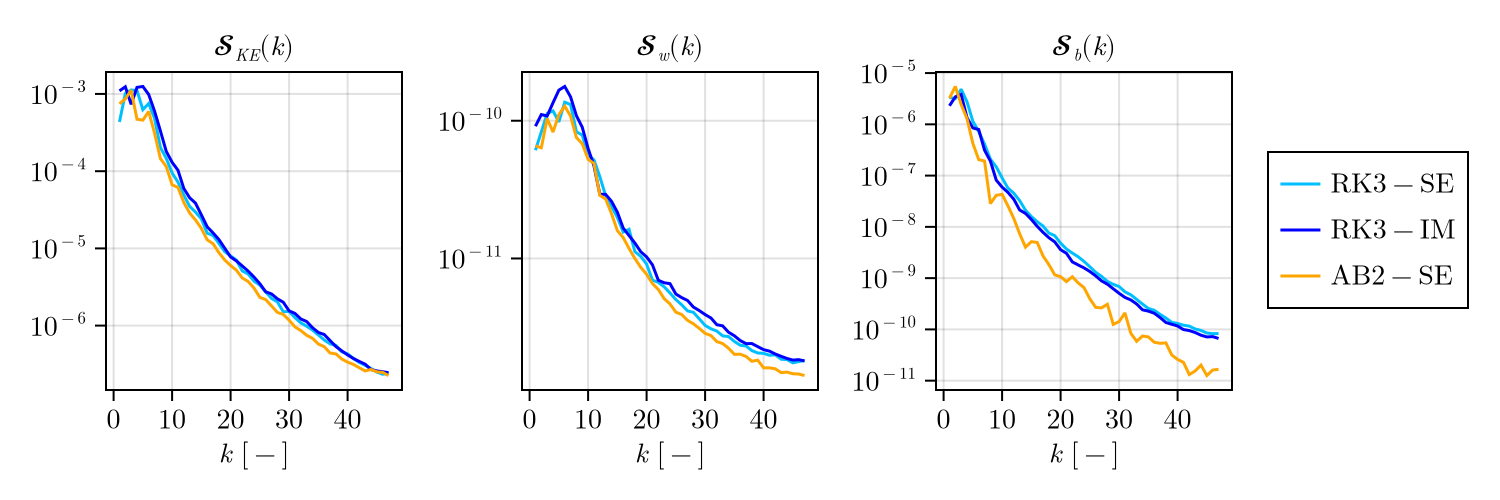

CairoMakie.Screen{PDF}


In [49]:
freq = freq ./ freq[2]

fig = Figure(size = (750, 250))
P1 = 1 # freq[2:end].^3
P2 = 1 # freq[2:end].^2
P3 = 1 # freq[2:end].^3


yt = [10.0^i for i in -20:10]
yl = [L"10^{%$i}" for i in -20:10]

ax  = Axis(fig[1, 1], 
           yscale=log10, 
           # xscale = log10,
           yticks = (yt, yl),
           xticks = ticks([0, 10, 20, 30, 40]),
           xlabel = L"k\text{ [-]}",
           ylabel = "",
           title = L"\mathcal{S}_{KE}(k)")
lines!(ax, freq[2:end], P1 .* (specUrl[2:end] .+ specVrl[2:end]), color=c1)
lines!(ax, freq[2:end], P1 .* (specUri[2:end] .+ specVri[2:end]), color=c2)
lines!(ax, freq[2:end], P1 .* (specUal[2:end] .+ specVal[2:end]), color=c3)
# ylims!(ax, 10^-2.5, 10^-0.5)

ax  = Axis(fig[1, 2], 
           yscale=log10, 
           # xscale = log10,     
           yticks = (yt, yl),      
           xticks = ticks([0, 10, 20, 30, 40]),
           xlabel = L"k\text{ [-]}",
           ylabel = "", 
           title = L"\mathcal{S}_{w}(k)")
lines!(ax, freq[2:end], P2 .* (specWrl[2:end]), color=c1)
lines!(ax, freq[2:end], P2 .* (specWri[2:end]), color=c2)
lines!(ax, freq[2:end], P2 .* (specWal[2:end]), color=c3)
# ylims!(ax, 10^-9.5, 10^-8)

ax  = Axis(fig[1, 3], 
           yscale=log10, 
           # xscale = log10,
           yticks = (yt, yl),
           xticks = ticks([0, 10, 20, 30, 40]),
           xlabel = L"k\text{ [-]}",
           ylabel = "", 
           title = L"\mathcal{S}_{b}(k)")
lines!(ax, freq[2:end], P3 .* (specBrl[2:end]), color=c1, label=L"\text{RK3-SE}")
lines!(ax, freq[2:end], P3 .* (specBri[2:end]), color=c2, label=L"\text{RK3-IM}")
lines!(ax, freq[2:end], P3 .* (specBal[2:end]), color=c3, label=L"\text{AB2-SE}")
# ylims!(ax, 1e-4, 1e-2)
Legend(fig[1, 4], ax)
display(fig)

CairoMakie.save(path * "spectra-coast.pdf", fig)

95000.0